In [240]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from tdsm.misc.plot import scatter_movie, imshow_movie

In [242]:
import jax.random
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun, WeaklyDiagonalControlTerm
import random



In [289]:
import jax.random
from diffrax import (ControlTerm, Euler, Heun, MultiTerm, ODETerm, SaveAt,
                     VirtualBrownianTree, diffeqsolve)
from jax import jit, vmap

import jax
import jax.numpy as jnp


def get_ic_osc(key):
    mu_0 = jnp.asarray([0, 10])
    ic = jax.random.normal(key, (2,))
    ic = (ic*0.5) - mu_0
    return ic


def get_2d_osc(mu):
    def drift(t, y, *args):
        xi, gamma, w = 0.22, mu, 1.0
        x1, x2 = y
        x1_dot = x2
        x2_dot = -2*xi*w*x2 + w**2*x1 - w**2*gamma*x1**3
        return jnp.asarray([x1_dot, x2_dot])

    def diffusion(t, y, *args):
        return jnp.asarray([0, 1])

    return drift, diffusion


# def get_ic_osc(key):
#     mu_0 = jnp.asarray([0, 0])
#     ic = jax.random.normal(key, (2,))
#     return ic

# def get_2d_osc(mu):
#     def drift(t, y, *args):
#         x1, x2 = y
#         x1_dot = x2
#         x2_dot = -x1
#         return jnp.asarray([x1_dot, x2_dot])*0.0

#     def diffusion(t, y, *args):
#         return jnp.asarray([1.0, 1.0])

#     return drift, diffusion

# import random



def solve_sde(drift, diffusion, t_eval, get_ic, n_samples, dt=1e-2, key=None):

    @jit
    def solve_single(key):
        t0, t1 = t_eval[0], t_eval[-1]
        ikey, skey = jax.random.split(key)
        y0 = get_ic(ikey)
        brownian_motion = VirtualBrownianTree(
            t0, t1, tol=1e-3, shape=y0.shape, key=skey)
        terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(
            diffusion, brownian_motion))
        solver = Euler()
        saveat = SaveAt(ts=t_eval)
        sol = diffeqsolve(terms, solver, t0, t1, dt0=dt,
                          y0=y0, saveat=saveat, max_steps=int(1e6))
        return sol.ys

    if key is None:
        key = jax.random.PRNGKey(random.randint(0, 1e6))
    keys = jax.random.split(key, num=n_samples)
    sols = vmap(solve_single)(keys)

    return sols


In [313]:
from scipy.special import roots_legendre, eval_legendre
def gauss_quadrature_weights_points(n, a=0, b=1):
    points, weights = roots_legendre(n)
    points = 0.5 * (points + 1) * (b - a) + a
    weights = weights * 0.5 * (b - a)
    return points, weights

bs_t = 300
t0, t1 = 0.0, 14
t_eval, t_weights = gauss_quadrature_weights_points(bs_t, a=t0, b=t1)
z, T = jnp.asarray([t0]), jnp.asarray([t1])
t_eval = jnp.concatenate([z, t_eval, T])

t_train = t_eval / t1
t_train = t_train.reshape(-1,1)
t_weights = t_weights / t1
# t_weights = t_weights * t1

In [314]:
n_samples = 20_000
# n_t = 1000
# t0, t1 = 0, 6
# t_eval = np.linspace(t0, t1, n_t)
mu = 0.05
drift, diffusion = get_2d_osc(mu)
sols = solve_sde(drift, diffusion, t_eval, get_ic_osc, n_samples)
sols = rearrange(sols, 'N T D -> T N D')

In [315]:
from tdsm.data.utils import normalize
sols, d_shift, d_scale = normalize(
    sols, axis=(0, 1), return_stats=True, method='01')

In [316]:
scatter_movie(sols)

In [317]:
from tdsm.net.build import build_colora
from typing import List, Optional

import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

from tdsm.net.networks import DNN
from tdsm.net.utils import init_net, merge, split

key = jax.random.PRNGKey(random.randint(0,1e8))

x_dim = 2
mu_t_dim = 1
u_dim = 1

u_layers = ['C', 'C', 'C', 'C', 'C', 'C', 'C'] # two tdsm layers with 1 alpha each means we will have laten dim of 2
h_layers = ['D', 'D', 'D']
rank = 3
full = True

lora_filter = ['alpha']

u_hat_config = {'width': 45, 'layers': u_layers}
h_config = {'width': 15, 'layers': h_layers}

net_u = DNN(**u_hat_config, out_dim=u_dim, period=None, bias=False)
params_init, u_apply = init_net(net_u, x_dim, key=key)

# split up the params of u into the offline params (theta) and the online params (phi)
phi_init, theta_init = split(params_init, lora_filter)
flat_phi, phi_unravel = ravel_pytree(phi_init)
n_phi = len(flat_phi)

net_h = DNN(**h_config, out_dim=n_phi, period=None, bias=False)
psi_init, h_fn = init_net(net_h, mu_t_dim, key=key)

# now we define a wrapper over the u neural network
# this will allow us to take theta and phi sepearatly
# and then it will automatically merge them and pass the resulting
# combined paramters to u_apply
# it also unravels phi so that we can pass in phi as a vector that is output from h

def build_u_hat(u_apply, phi_unravel):
    def u_hat(theta, phi, *args):
        phi = phi_unravel(phi)
        theta_phi = merge(theta, phi)
        return u_apply(theta_phi, *args)
    return u_hat

u_fn = build_u_hat(u_apply, phi_unravel)


params_init = (psi_init, theta_init)


def s(t, x, params):
    psi, theta = params
    phi = h_fn(psi, t)

    return jnp.squeeze(u_fn(theta, phi, x))


In [318]:
# net_u = DNN(width=64, layers=['D']*4, out_dim=u_dim, period=None)
# params_init, u_apply = init_net(net_u, x_dim+1, key=key)


# def s(t, x, params):
#     x_t = jnp.concatenate([x,t])
#     return jnp.squeeze(u_apply(params, x_t))


In [319]:

from jax import jit, jvp, grad, jacrev, jacfwd
from functools import partial


def trace_estimator(fn, argnum=0):
    
    d_fn = jacrev(fn, argnums=argnum)

    def est_trace(key, *args, **kwargs):
        args = list(args)
        primal = args[argnum]
        eps = jax.random.normal(key, shape=primal.shape)
        def s_dx_wrap(x):
            return d_fn(*args[:argnum], x, *args[argnum+1:], **kwargs)
        dx_val, jvp_val = jax.jvp(s_dx_wrap, (primal,), (eps,))
        trace = jnp.dot(eps, jvp_val)
        return dx_val, trace

    return est_trace


In [320]:
from jax import jit, jvp, grad, jacrev, jacfwd
from functools import partial

s_dt = jacrev(s, 0)
s_dt_Vx = vmap(s_dt, (None, 0, None))
s_dt_Vx_Vt = vmap(s_dt_Vx, (0, None, None))

s_Vx = vmap(s, in_axes=(None, 0, None))
s_Vx_Vt = vmap(s_Vx, in_axes=(0, None, None))
s_dx = jacrev(s, 1)
s_dx_Vx = vmap(s_dx, in_axes=(None, 0, None))
s_ddx_Vx = vmap(jacfwd(s_dx, 1), (None, 0, None))
s_dt_dx = jacrev(s, (0, 1))
s_dt_dx_Vx = vmap(s_dt_dx, in_axes=(None, 0, None))

trace_dds = trace_estimator(s, argnum=1)
trace_dds_Vx = vmap(trace_dds, (None, None, 0, None))


In [321]:
from jax.experimental.host_callback import id_print, id_tap

import jax.flatten_util


noise = 0.0
sigma = 1e-1


res = []
def save_on_host(data, transforms):
    res.append(data)

def am_loss(psi_theta, x_t_batch, t_batch, key):

    # x_t_batch += jax.random.normal(key, shape=x_t_batch.shape)*sigma
    T, N, D = x_t_batch.shape
    T, MT = t_batch.shape
    bound = s_Vx(t_batch[0], x_t_batch[0], psi_theta) - \
        s_Vx(t_batch[-1], x_t_batch[-1], psi_theta)
        
    x_t_batch = x_t_batch[1:-1]
    t_batch = t_batch[1:-1]

    xt_tensor = rearrange(x_t_batch, 'T N D -> T (N D)')
    xt_tensor = jnp.hstack([xt_tensor, t_batch])

    def interior_loss(xt_tensor):
        x_batch, t = xt_tensor[:-MT], xt_tensor[-MT:]
        x_batch = rearrange(x_batch, '(N D) -> N D', D=D)

        # id_print(jnp.linalg.norm(x_batch))
        ut = s_dt_Vx(t, x_batch, psi_theta)
        ut = jnp.squeeze(ut)
        # # entropic
        if sigma > 0.0:

            gu, trace_ets = trace_dds_Vx(key, t, x_batch, psi_theta)
            ent = trace_ets*sigma**2*0.5
        else:
            gu = s_dx_Vx(t, x_batch, psi_theta)
            ent = 0.0
        gu = 0.5*jnp.sum(gu**2, axis=1)

        return gu.mean() + ut.mean() + ent.mean()

    interior = vmap(interior_loss)(xt_tensor)

    # id_tap(save_on_host, [gu.mean(), ut.mean(),(gu*t_weights).mean(), (ut*t_weights).mean()])

    # interior = (gu*t_weights) + (ut*t_weights)
    interior *= t_weights
    loss = (bound.mean() + interior.sum())

    # v =jax.flatten_util.ravel_pytree(psi_theta[1])[0]
    # reg = 1.5e-1*jnp.linalg.norm(v)

    
    return loss 


def get_rand_idx(key, N, bs):
    idx = jnp.arange(0, N)
    return jax.random.choice(key, idx, shape=(bs,), replace=False)


def get_data_fn(sols, t_data, bs_n, bs_t):
    T, N, D = sols.shape

    def args_fn(key):

        nonlocal sols
        nonlocal t_data

        key, keyt = jax.random.split(key)
 
        # t_idx = jax.random.choice(keyt, jnp.arange(1,T-1), shape=(bs_t-2,), replace=False)
        # start, end = jnp.asarray([0]), jnp.asarray([T-1])
        # t_idx = jnp.concatenate([start, t_idx, end])

        keys = jax.random.split(key, num=bs_t+2)
        keys *= 0 + key[0] 
        sample_idx = vmap(get_rand_idx, (0, None, None))(keys, N, bs_n)
        
        sols_sample = sols #[t_idx]
        t_sample = t_data #[t_idx]

        sols_sample = sols_sample[np.arange(len(sols_sample))[:, None], sample_idx]

        return sols_sample, t_sample
    return args_fn




In [322]:
bs_n = 512
key = jax.random.PRNGKey(np.random.randint(0,1e5))
args_fn = get_data_fn(sols, t_train, bs_n, bs_t)
x_t_batch, t_batch = args_fn(key)
x_t_batch.shape, t_batch.shape

((302, 512, 2), (302, 1))

In [323]:
from tdsm.train.adam import adam_opt

last_params, opt_params, loss_history = adam_opt(params_init, am_loss, args_fn, steps=3_000, learning_rate=1e-2, verbose=True, scheduler=True, key=key)



  0%|          | 0/3000 [00:00<?, ?it/s]

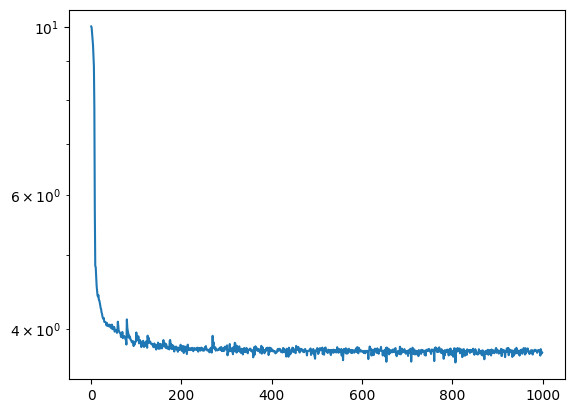

In [324]:
plt.semilogy(loss_history+10)
plt.show()

In [325]:
# res = np.asarray(res)
# plt.semilogy(res)
# plt.legend(['gu','ut', 'gu weight', 'ut weight'])
# plt.show()

# plt.plot(res)
# plt.legend(['gu','ut', 'gu weight', 'ut weight'])
# plt.show()

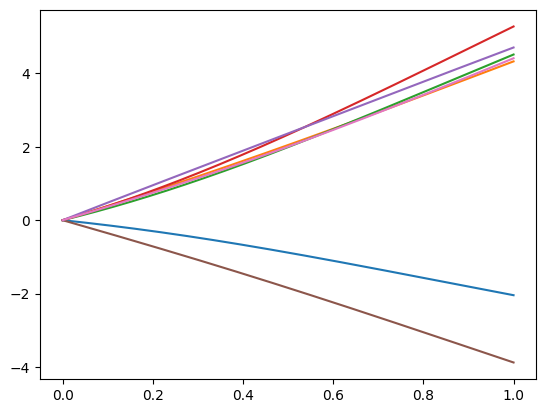

In [326]:
phis = vmap(h_fn, (None, 0))(opt_params[0], t_train)
plt.plot(t_train, phis)
plt.show()

In [327]:
nx = 100
xA, xB = sols[:, :, 0].min(), sols[:, :, 0].max()
yA, yB = sols[:, :, 1].min(), sols[:, :, 1].max()
x1, x2 = jnp.linspace(xA, xB, nx), jnp.linspace(yA, yB, nx)
m_grids = jnp.meshgrid(x1, x2,  indexing='ij')
x_grid = jnp.asarray([m.flatten() for m in m_grids]).T

t_test = t_train

pred = s_Vx_Vt(t_test, x_grid, opt_params)
pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_test), N1=nx, N2=nx)

imshow_movie(pred, live_cbar=True)


In [328]:
# t_test = t_train[::2]
# pred = s_dt_Vx_Vt(t_test, x_grid, opt_params)
# pred = jnp.squeeze(pred)
# pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_test), N1=nx, N2=nx)

# plt.plot(t_test, np.mean(pred, axis=(1,2)))
# plt.show()
# np.mean(pred), t_test.shape
# # normalize_C =  np.linalg.norm(pred, axis=(-2,-1), keepdims=True)
# # pred = pred / normalize_C



In [329]:
# t_test = t_train[::2]

# int_s_qt = 0.0
# for t, t_sol in zip(t_test, sols):
#     int_s_qt += s_dt_Vx(t, t_sol, opt_params).mean()

# int_s_qt / len(sols)



In [330]:
# from scipy.special import roots_legendre, eval_legendre
# def gauss_quadrature_weights_points(n, a=0, b=1):
#     points, weights = roots_legendre(n)
#     points = 0.5 * (points + 1) * (b - a) + a
#     weights = weights * 0.5 * (b - a)
#     return points, weights

# t_test, t_weights = gauss_quadrature_weights_points(20)

# t_test = t_test.reshape(-1,1)
# pred = s_dt_Vx_Vt(t_test, x_grid, opt_params)
# pred = jnp.squeeze(pred)
# pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_test), N1=nx, N2=nx)
# pred = pred*t_weights[:, None, None]
# plt.plot(t_test, np.mean(pred, axis=(1,2)))
# plt.show()
# np.mean(pred)
# # normalize_C =  np.linalg.norm(pred, axis=(-2,-1), keepdims=True)
# # pred = pred / normalize_C



In [331]:
# t_test = t_train[::50]
# pred = s_dt_Vx_Vt(t_test, x_grid, opt_params)
# pred = jnp.squeeze(pred)
# pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_test), N1=nx, N2=nx)

# plt.plot(t_test, np.mean(pred, axis=(1,2)))
# plt.show()
# np.mean(pred)
# # normalize_C =  np.linalg.norm(pred, axis=(-2,-1), keepdims=True)
# # pred = pred / normalize_C



In [332]:
from tdsm.data.ode import odeint_rk4

t_int = np.squeeze(t_train)
dt = t_int[1]
y0 = sols[0]
def fn(t, y):
    f = jnp.squeeze(s_dx_Vx(t.reshape(1), y, opt_params))
    return f
    
    
int_sol = odeint_rk4(fn, y0, t_int)
     

In [333]:


def get_ic_scaled(key):
    ic = get_ic_osc(key)
    ic = (ic - np.squeeze(d_shift)) / np.squeeze(d_scale)
    return ic


def drift(t, y, *args):
    f = jnp.squeeze(s_dx(t.reshape(1), y, opt_params))
    return f

def diffusion(t, y, *args):
    return sigma * jnp.ones_like(y)

int_sol = solve_sde(drift, diffusion, t_int, get_ic_scaled, n_samples, dt=1e-3)
int_sol = rearrange(int_sol, 'N T D -> T N D')

In [334]:
ss = 20
all_sol = jnp.hstack([sols, int_sol])
L = int_sol[ :, ::ss].shape[1]
cs = [*['r']*L,*['b']*L]

In [335]:
scatter_movie(all_sol[:, ::ss], t=t_int, c=cs, alpha=0.3)#, xlim=[0,1], ylim=[0,1], save_to='/p/home/jmb/sc/rommc/roll_am', fps=5)

In [336]:
# t = 0.9
# nx = 25
# xA, xB = -0, 1.0
# yA, yB = -1, 1.0
# x1, x2 = jnp.linspace(xA, xB, nx), jnp.linspace(yA, yB, nx)
# m_grids = jnp.meshgrid(x1, x2)
# x_grid = jnp.asarray([m.flatten() for m in m_grids]).T

# phi = h_fn(opt_psi, jnp.asarray([t]))
# gf = grad_u_v_x(opt_theta, phi, x_grid)
# gf = rearrange(gf, '(nx ny) o D -> nx ny (o D)', nx=nx, ny=nx)


# X, Y = m_grids

# # Extract the gradient components
# U = gf[:, :, 0]
# V = gf[:, :, 1]
# plt.xlim(x1.min(), x1.max())
# plt.ylim(x2.min(), x2.max())

# it = int(len(t_int) * t)
# plt.scatter(x=int_sol[it,:,0],y=int_sol[it,:,1])

# plt.quiver(X, Y, U, V, angles='xy')
# plt.show()